### Imports & setup

In [1]:
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import os
import pickle
from pathlib import Path
import rootutils
from scipy.spatial.distance import squareform
import seaborn as sns
# import torch
# from torchvision import transforms

ROOT = rootutils.setup_root(".", indicator=".project-root", pythonpath=True)

from src.analysis import cka, rsa
from rsa import get_rsa_matrix
from src.analysis.representations import (
    get_average_class_representations, 
    get_class_representations,
    compute_cka_and_kernel_matrices
)
from src.data.data_module import MyDataModule
from src.model.model_module import LitMML, MLMWrapper
from src.model.utils import get_model_and_processor
from src.utils.utils import save_as_pickle

In [2]:
dataset_name = "CIFAR10"
checkpoints = "full_dataset_aug_mlm"
which_layer = "encoder" #"projection"

device = "cuda:1"

CKPT_DIR = Path("/home/data/bhavin/0.1_and_0.5_ckpts")
CKPT_CONFIG_DIR = os.path.join(ROOT, "configs/checkpoints")
SAVE_DATA_DIR = os.path.join(ROOT, "data", "representations")
SAVE_FIGURES_DIR = os.path.join(ROOT, "plots")
cfg_checkpoints = OmegaConf.load(os.path.join(CKPT_CONFIG_DIR, f"{checkpoints}.yaml"))

In [3]:
# Load config
cfg_path = "../../configs"

overrides = [f"checkpoints={checkpoints}",
             f"data.datasets=[{dataset_name}]",
            ]

with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(config_name="rsa.yaml", overrides=overrides)
    #config = compose(overrides=[f"data.datasets=[f{DATASET}]"])
print(cfg)

{'model': {'model': {'image_encoder_name': 'google/vit-base-patch16-224', 'text_encoder_name': 'google-bert/bert-base-uncased', 'tokenizer': {'use_fast': False}}}, 'data': {'datasets': ['CIFAR10'], 'dataloader': {'coco_val': {'batch_size': 128, 'shuffle': False}, 'test': {'batch_size': 128, 'shuffle': False, 'num_workers': 8, 'pin_memory': True}}, 'root': '${paths.data_dir}', 'Places365': {'root': '/home/data/places365/'}, 'use_subset_probe': {'value': False, 'subset_fraction': 0.1}, 'dataset': {'val': ['coco_val_dummy'], 'transforms': {'enabled': True, 'RandAugment': {'num_ops': 3, 'magnitude': 8}}, 'max_seq_length': 72, 'coco': {'root': '/home/data/mscoco_captions/', 'split_train': '/home/phisch/multimodal/my_datasets/coco_karpathy_train.json', 'split_val': '${paths.root_dir}src/data/datasets/coco_karpathy_val.json', 'split_test': '/home/phisch/multimodal/my_datasets/coco_karpathy_test.json'}, 'vg': {'data_dir': '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/VG_Bhavin/VG'}, 

### Workflow
1. Get model representations for each class of a dataset (average class representation)
2. Compute RDM by measuring (dis-)similarites of class representations
3. Compute RSA by measuring (dis-)similarities of RDMs

### Get model representations
1. Load model & dataset
2. Compute representations and calculate average class representations
3. Store average class representations

## Load model & dataset

In [4]:
# Load model
model, processor = get_model_and_processor(cfg.model)
model = MLMWrapper(model)

In [5]:
# Load dataset
data_module = MyDataModule(
    cfg.data,
    processor,
)
all_test_dataloaders = data_module.get_test_dataloaders()
dataloader = all_test_dataloaders[dataset_name]["test"]
num_classes = dataloader.dataset.num_classes
class_names = dataloader.dataset.classnames
print(num_classes)
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Classnames: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
Template: no template
Embed classnames, compute representation
1. Tokenize -> processor
2. forward through model -> rep of every classname
3. classname representations: (num_classes, embed_dim)

In [29]:
# Create classname embeddings
# templates = cfg.data.dataset.caption_template
# templates = ["a photo of a {}."]
templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.'
]
if isinstance(templates, str):
    templates = [templates]
print(templates)

['a photo of a {}.', 'a blurry photo of a {}.', 'a black and white photo of a {}.', 'a low contrast photo of a {}.', 'a high contrast photo of a {}.', 'a bad photo of a {}.', 'a good photo of a {}.', 'a photo of a small {}.', 'a photo of a big {}.', 'a photo of the {}.', 'a blurry photo of the {}.', 'a black and white photo of the {}.', 'a low contrast photo of the {}.', 'a high contrast photo of the {}.', 'a bad photo of the {}.', 'a good photo of the {}.', 'a photo of the small {}.', 'a photo of the big {}.']


In [8]:
device="cuda:0"

In [ ]:
from datetime import datetime

from src.callbacks.zeroshot_callback import _create_zero_shot_classifier

print(f"Computing class representations for checkpoints {checkpoints}")

save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

for ckpt in cfg_checkpoints:
    model_name = cfg_checkpoints[ckpt]["model"]
    ckpt_path = cfg_checkpoints[ckpt]["path"]
    # files = os.listdir(os.path.join(CKPT_DIR, ckpt))
    # if "last.ckpt" in files:
    #     files.remove("last.ckpt")
    # ckpt_path = os.path.join(CKPT_DIR, ckpt, files[0])
    
    # Load checkpoint
    print(f"Loading model {ckpt}:{model_name} from checkpoint", ckpt_path)    
    lit_model = LitMML.load_from_checkpoint(ckpt_path, model=model, processor=processor, map_location=device)
    model, processor = lit_model.model, lit_model.processor
    vision_forward_func = lambda x: model.get_image_features(pixel_values=x)
    # text_forward_func = lambda x, y: model.get_text_features(input_ids=x, attention_mask=y)
    # del lit_model
    # torch.cuda.empty_cache()
    
    print("Computing class representations")
    class_representations_texts = _create_zero_shot_classifier(
        forward_func=lambda x, y: model.get_text_features(input_ids=x, attention_mask=y),
        tokenizer=processor,
        classnames=class_names,
        templates=templates,
        device=device,
    )
    class_representations_texts = class_representations_texts.T.detach().cpu().numpy()
    
    # class_representations_image = get_class_representations(dataloader,
    #                                                   vision_forward_func,
    #                                                   num_classes,
    #                                                   device,
    #                                                   )
    # avg_class_representations = get_average_class_representations(class_representations_image)
    
    # save_file_path = os.path.join(save_file_dir, f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl")
    # save_as_pickle(avg_class_representations, save_file_path)
    # print(f"Saved: {save_file_path}")
    
    dictionary = {
            "modality": "text",
            "layer": "text_projection",
            "templates": templates,
            "data": class_representations_texts,
            "embedding_dim": class_representations_texts.shape[1],
            "dtype": str(class_representations_texts.dtype),
            "created": datetime.now().strftime("%Y-%m-%d"),
            "notes": "",
        }
    
    save_file_path = os.path.join(save_file_dir, f"{dataset_name}-{ckpt}-text_representations.pkl")
    if os.path.exists(save_file_path):
        with open(save_file_path, "rb") as f:
            data = pickle.load(f)
        if "representations" in data and isinstance(data["representations"], list):
            data["representations"].append(dictionary)
        else:
            data["representations"] = [dictionary]
    else:
        data = {
            "dataset": dataset_name,
            "model": model,
            "class_names": class_names,
            "representations": [dictionary]
        }
    with open(save_file_path, "wb") as f:
        pickle.dump(data, f)
    print(f"Saved: {save_file_path}")


Computing class representations for checkpoints full_dataset_aug_mlm
Loading model 3burj4np:CLIP from checkpoint /home/data/bhavin/higher_augmentations_ckpts/3burj4np/last.ckpt


/home/phisch/venv_py3.8/py3.8/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.3, which is newer than your current Lightning version: v2.2.0.post0


Computing class representations
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-text_representations.pkl
Loading model 7m9tx2jf:CLIP + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/7m9tx2jf/last.ckpt
Computing class representations
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-text_representations.pkl
Loading model 95ddsmmz:CLIP + SimCLR from checkpoint /home/data/bhavin/higher_augmentations_ckpts/95ddsmmz/last.ckpt


Computing class representations
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-text_representations.pkl
Loading model ng70n4a4:CLIP + SimCLR + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/ng70n4a4/last.ckpt
Computing class representations
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-text_representations.pkl
Loading model p99godxb:SimCLR from checkpoint /home/data/bhavin/higher_augmentations_ckpts/p99godxb/last.ckpt
Computing class representations
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-text_representations.pkl
Loading model xpbl8wfc:SimCLR + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/xpbl8wfc/last.ckpt
Computing class representations
Saved: /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-text_representations.pkl
Loading model bj2tw5qt:SimCLR +

## RDM

### Uni-modal RDM

In [7]:
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-text_representations.pkl"
    file_path = os.path.join(save_file_dir, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-text_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-text_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-text_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-text_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-text_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-text_representations.pkl
Loading mean class representations from /home/phisch/multimodal/

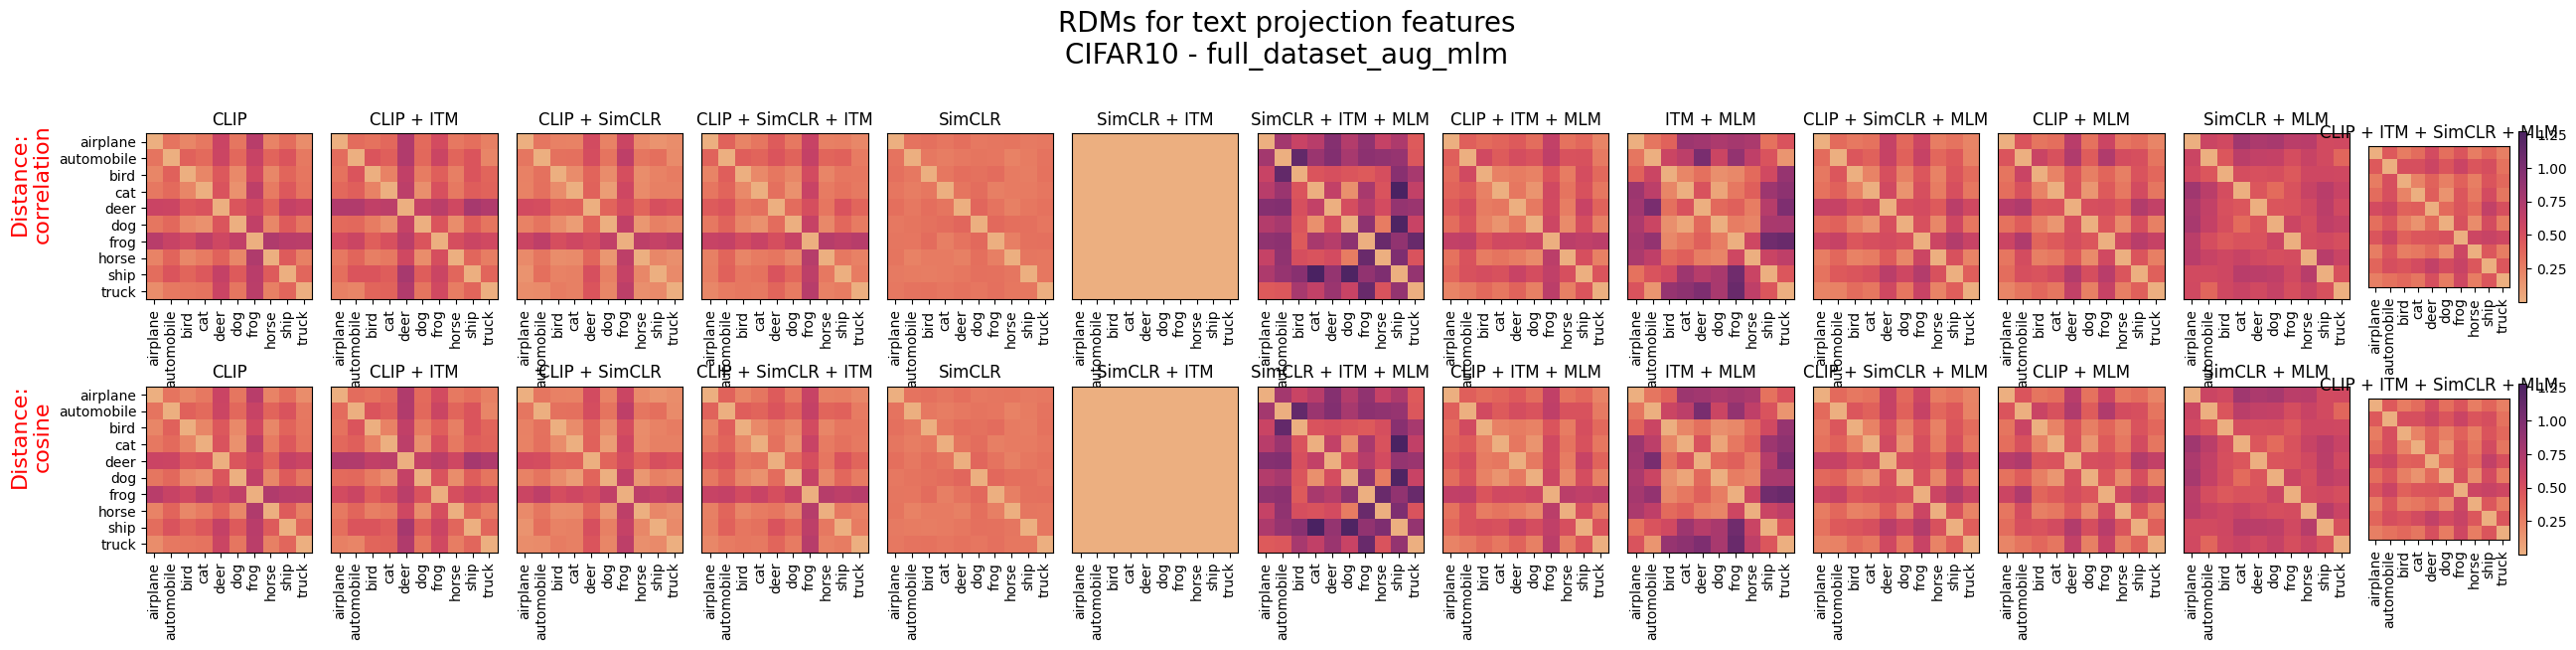

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.spatial.distance import squareform

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "correlation",
    "cosine",
]

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(mean_class_representations), 
    figsize=(2 * len(mean_class_representations), 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=0.5)  # Adjust spacing between subplots
fig.suptitle(
    f"RDMs for text projection features\n{dataset_name} - {checkpoints}",
    fontsize=20,
    y=1.05,
    # fontweight="bold",
    color="black",
)

for method_idx, method in enumerate(METRICS_FOR_RDMS):
    axs[method_idx, 0].set_ylabel(f"Distance:\n{method}", color="red", y=0.7, fontsize=16)
    axs[method_idx, 0].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    for ax in axs[method_idx, 1:]:
        ax.set_yticks([])
    
    # create a single norm to be shared across all images
    rdms = {model: rsa.get_rdm(mean_class_representations[model], metric=method) for _, model in enumerate(mean_class_representations)}
    vmin = np.min([np.min(rdms[model]) for _, model in enumerate(rdms)])
    vmax = np.max([np.max(rdms[model]) for _, model in enumerate(rdms)])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    # print(vmin, vmax)

    for model_idx, model in enumerate(rdms):
        img = axs[method_idx, model_idx].imshow(
            squareform(rdms[model]), cmap=sns.color_palette("flare", as_cmap=True), norm=norm
        )
        axs[method_idx, model_idx].set_title(cfg_checkpoints[model]["model"])
        axs[method_idx, model_idx].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )

    # Add a single colorbar for the row
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=sns.color_palette("flare", as_cmap=True)), ax=axs[method_idx, len(rdms)-1], location='right', fraction=0.1)#, pad=0.1)
    # cbar = fig.colorbar(
    #     imgs[-1], ax=axs[method_idx, :], location='right', fraction=0.05, pad=0.1
    # )
    # cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

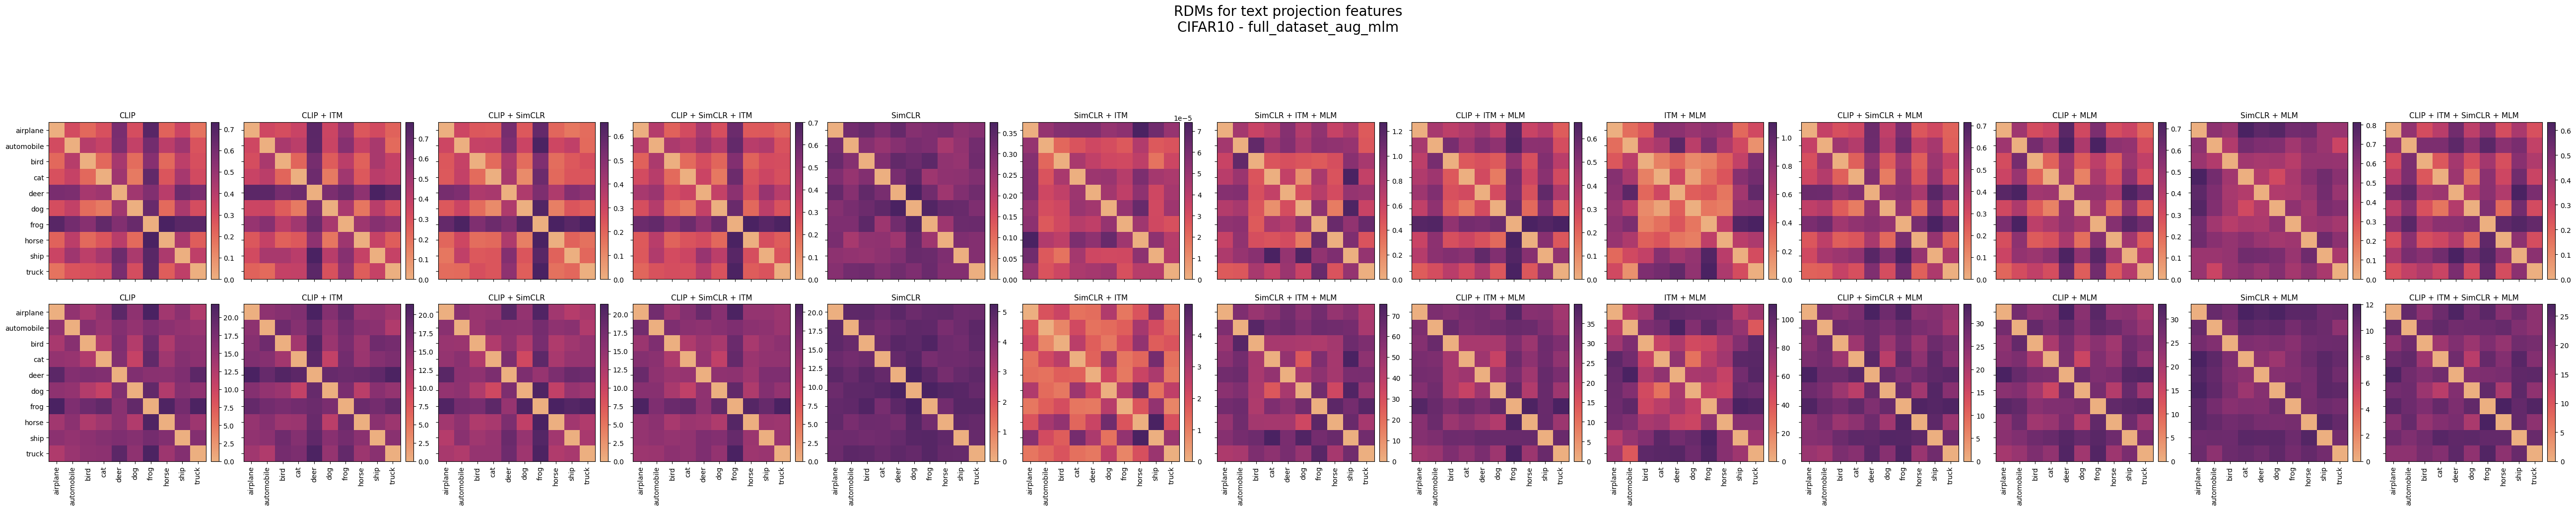

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import squareform

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "correlation",
    "euclidean",
]

# Create a GridSpec to manage the layout
num_rows = len(METRICS_FOR_RDMS)
num_cols = len(mean_class_representations)
fig = plt.figure(figsize=(4 * num_cols, 6 * num_rows))
fig.suptitle(
    f"RDMs for text projection features\n{dataset_name} - {checkpoints}",
    fontsize=20,
    y=0.95,
)
plt.subplots_adjust(top=0.88)

grid = AxesGrid(fig, 111,  # similar to subplot(122)
                nrows_ncols=(num_rows, num_cols),
                axes_pad=0.50,
                label_mode="L",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                # cbar_size="9%",
                cbar_pad=0.1,
                )

for i in range(num_rows * num_cols):
    model_name = list(mean_class_representations.keys())[i%num_cols]
    representations = mean_class_representations[model_name]
    a = rsa.get_rdm(representations, metric=METRICS_FOR_RDMS[i//num_cols])
    img = grid[i].imshow(
        squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
    )
    grid[i].set_title(cfg_checkpoints[model_name]["model"], fontsize=11)
    grid[i].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )
    grid[i].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    grid.cbar_axes[i].colorbar(img)
    # if i == 0:#(num_cols-1):
    #     print(i)
    #     grid.cbar_axes[i].colorbar(img)
    # if i == 13:#(2*num_cols-1):
    #     print(i)
    #     grid.cbar_axes[i].colorbar(img)
# print(grid.cbar_axes[0])
# for cax in grid.cbar_axes:
#     cax.axis[cax.orientation].set_label('Foo')

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

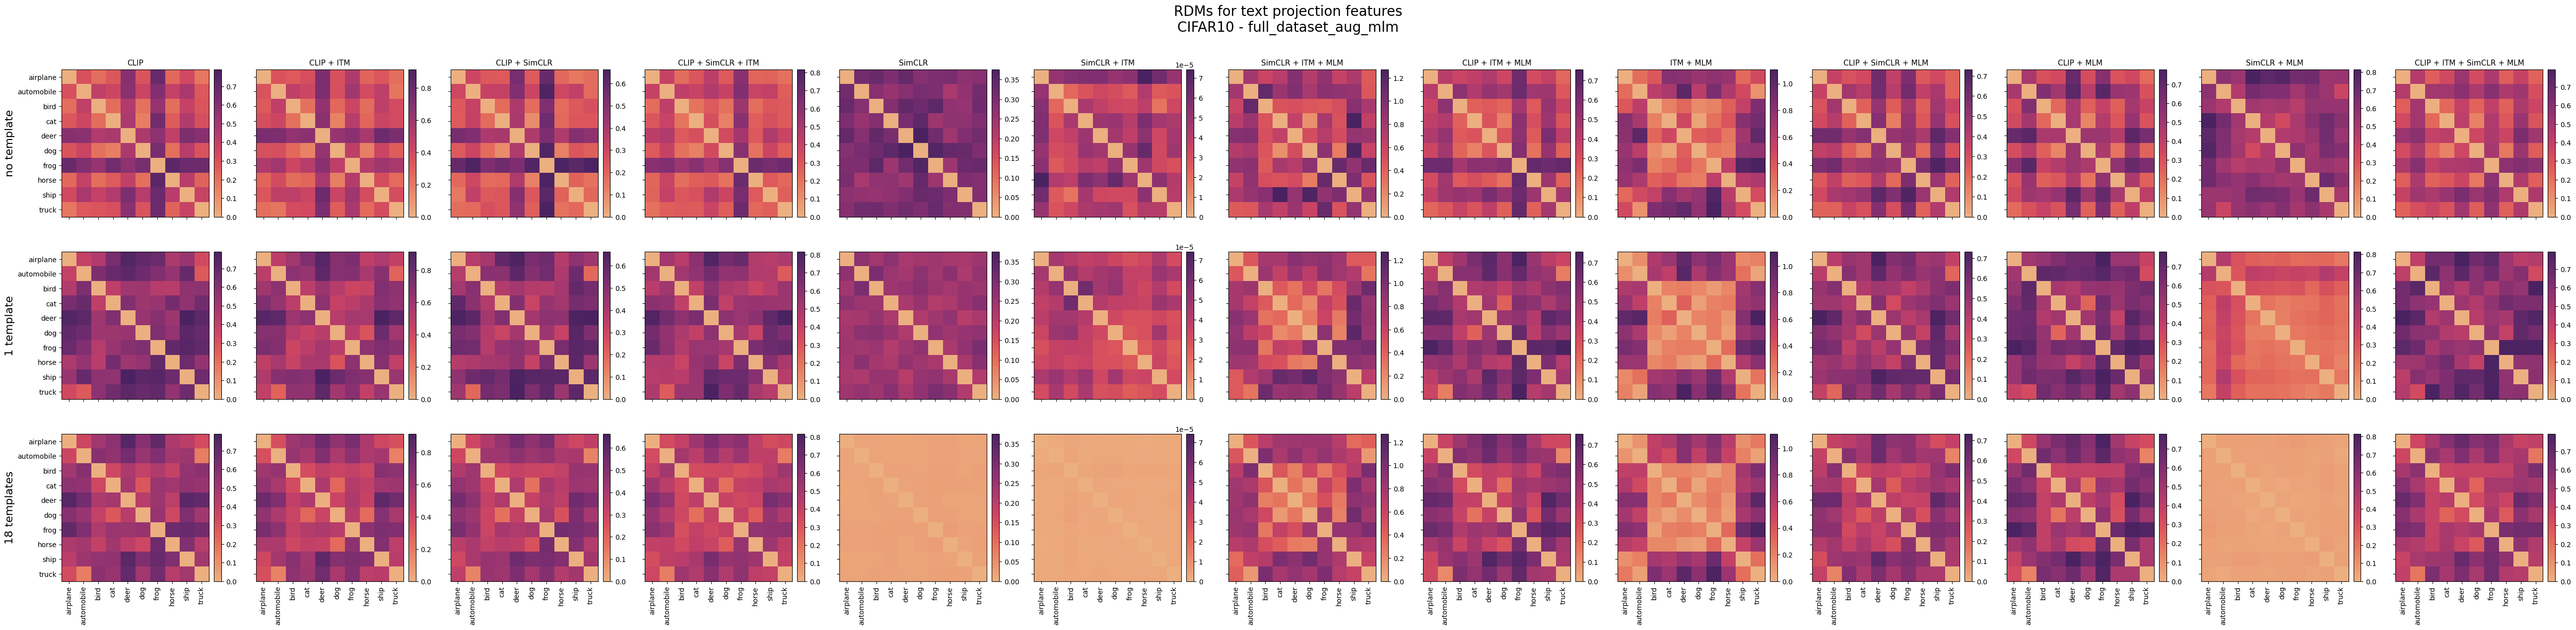

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import squareform
import seaborn as sns

METRIC = "cosine"

# Get the number of templates for each row
any_model_key = next(iter(mean_class_representations))
template_counts = ["no template", "1 template", "18 templates"]

num_rows = len(template_counts)
num_cols = len(mean_class_representations)
class_names = mean_class_representations[any_model_key]["class_names"]
num_classes = len(class_names)

fig = plt.figure(figsize=(4 * num_cols, 4.5 * num_rows))
fig.suptitle(f"RDMs for text projection features\n{dataset_name} - {checkpoints}", fontsize=20, y=0.95)
plt.subplots_adjust(top=0.9)

grid = AxesGrid(
    fig, 111,
    nrows_ncols=(num_rows, num_cols),
    axes_pad=0.7,
    label_mode="L",
    share_all=True,
    cbar_location="right",
    cbar_mode="each",
    cbar_pad=0.1,
)

# Compute vmin and vmax per column (i.e., per model)
vmin_per_col = []
vmax_per_col = []

for model_info in mean_class_representations.values():
    rdms = [squareform(rsa.get_rdm(rep["data"], metric=METRIC)) 
            for rep in model_info["representations"]]
    all_vals = np.stack(rdms)
    vmin_per_col.append(all_vals.min())
    vmax_per_col.append(all_vals.max())


for col, (model_name, model_info) in enumerate(mean_class_representations.items()):
    for row, rep in enumerate(model_info["representations"]):
        index = row * num_cols + col
        data = rep["data"]
        rdm = rsa.get_rdm(data, metric=METRIC)
        ax = grid[index]

        img = ax.imshow(
            squareform(rdm),
            cmap=sns.color_palette("flare", as_cmap=True),
            vmin=vmin_per_col[col],
            vmax=vmax_per_col[col],
        )

        if row == 0:
            ax.set_title(cfg_checkpoints[model_name]["model"], fontsize=11)

        if col == 0:
            ax.set_yticks(range(num_classes))
            ax.set_yticklabels(class_names)
            ax.set_ylabel(f"{template_counts[row]}", fontsize=16)

        if row == num_rows - 1:
            ax.set_xticks(range(num_classes))
            ax.set_xticklabels(class_names, rotation=90)

        grid.cbar_axes[index].colorbar(img)

plt.tight_layout()
plt.show()


### Multi-modal RDM

In [ ]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

visual_representations = {}
text_representations = {}
for ckpt in cfg_checkpoints:
    for x in ["vis", "text"]:
        file_name = f"{dataset_name}-{ckpt}-mean_class_reps-{x}_proj.pkl"
        file_path = os.path.join(save_file_dir, file_name)
        print(f"Loading mean class representations from {file_path}")
        with open(file_path, "rb") as f:
            if x == "vis":
                visual_representations[ckpt] = pickle.load(f)
            else:
                text_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-text_proj.pkl
Loading mean class representations fr

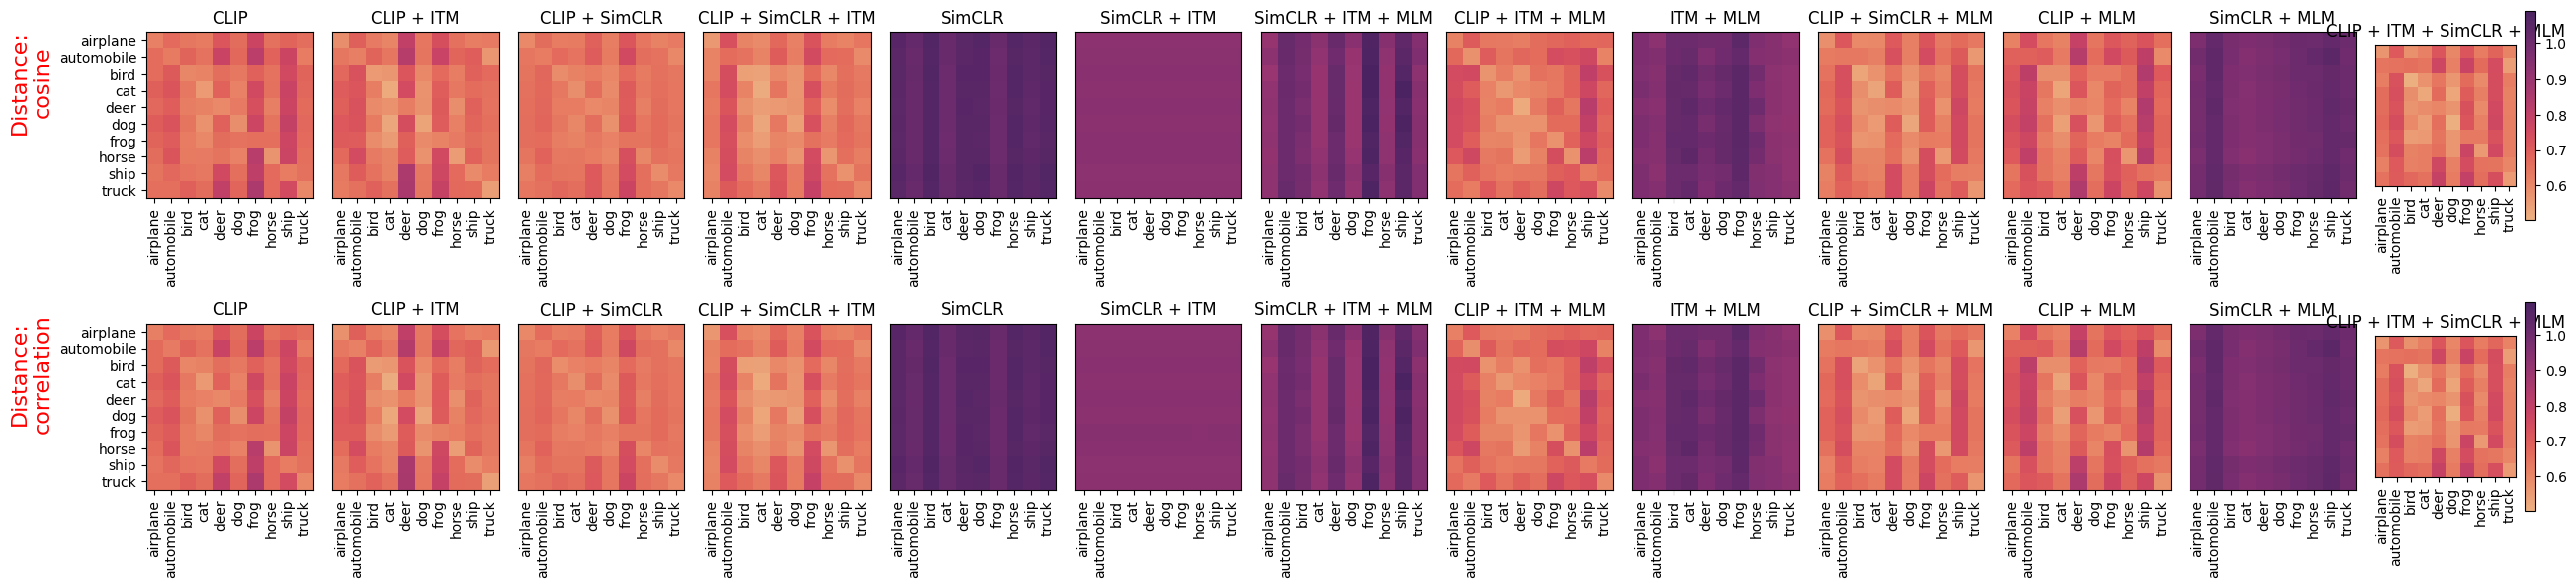

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from matplotlib import cm, colors

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "cosine",
    "correlation",
    # "euclidean",
]

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(visual_representations), 
    figsize=(2 * len(visual_representations), 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=0.5)  # Adjust spacing between subplots

for method_idx, method in enumerate(METRICS_FOR_RDMS):
    axs[method_idx, 0].set_ylabel(f"Distance:\n{method}", color="red", y=0.7, fontsize=16)
    axs[method_idx, 0].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    for ax in axs[method_idx, 1:]:
        ax.set_yticks([])
    
    rdms = {model: rsa.get_multimodal_rdm(visual_representations[model],
                                          text_representations[model], 
                                          metric=method)
                                          for _, model in enumerate(visual_representations)}
    vmin = np.min([np.min(rdms[model]) for _, model in enumerate(rdms)])
    vmax = np.max([np.max(rdms[model]) for _, model in enumerate(rdms)])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Collect all heatmaps in a row for a single colorbar
    for model_idx, model in enumerate(rdms.keys()):
        img = axs[method_idx, model_idx].imshow(
            # squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
            rdms[model], cmap=sns.color_palette("flare", as_cmap=True), norm=norm
        )
        axs[method_idx, model_idx].set_title(cfg_checkpoints[model]["model"])
        axs[method_idx, model_idx].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )

    # Add a single colorbar for the row
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=sns.color_palette("flare", as_cmap=True)), ax=axs[method_idx, len(rdms)-1], location='right', fraction=0.1)#, pad=0.1)

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

In [ ]:
for i, key in enumerate(visual_representations):
    a = rsa.get_multimodal_rdm(visual_representations[key],
                               text_representations[key], 
                               metric="cosine")
    print(key, np.min(a), np.max(a))
# squareform(a)
# print(np.min(a))

3burj4np 0.556584565678371 0.850163543751313
7m9tx2jf 0.5158287663235048 0.8534078663274259
95ddsmmz 0.5778689720364484 0.7703158632506873
ng70n4a4 0.5144306858830754 0.7875061292618368
p99godxb 1.0016325187448147 1.073200989083093
xpbl8wfc 0.925750741505371 0.9395863097694329
bj2tw5qt 0.8924546223339089 1.0912836834920305
khb9ltyn 0.5159465431403965 0.8221809827155706
mkqp8hhx 0.9128271812015192 1.0499579475669807
txva2y48 0.5263291250684252 0.7687751030858582
shf56cne 0.5299984457131055 0.8449793026544177
gtp8w6c4 0.9385653463743968 1.0462553994559185
tibwkymx 0.5038835631402506 0.793045421886386


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.spatial.distance import squareform

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "correlation",
    "cosine",
]

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(mean_class_representations), 
    figsize=(2 * len(mean_class_representations), 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=0.5)  # Adjust spacing between subplots
fig.suptitle(
    f"RDMs for text projection features\n{dataset_name} - {checkpoints}",
    fontsize=20,
    y=1.05,
    # fontweight="bold",
    color="black",
)

for method_idx, method in enumerate(METRICS_FOR_RDMS):
    axs[method_idx, 0].set_ylabel(f"Distance:\n{method}", color="red", y=0.7, fontsize=16)
    axs[method_idx, 0].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    for ax in axs[method_idx, 1:]:
        ax.set_yticks([])
    
    # create a single norm to be shared across all images
    rdms = {model: rsa.get_rdm(mean_class_representations[model], metric=method) for _, model in enumerate(mean_class_representations)}
    vmin = np.min([np.min(rdms[model]) for _, model in enumerate(rdms)])
    vmax = np.max([np.max(rdms[model]) for _, model in enumerate(rdms)])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    # print(vmin, vmax)

    for model_idx, model in enumerate(rdms):
        img = axs[method_idx, model_idx].imshow(
            squareform(rdms[model]), cmap=sns.color_palette("flare", as_cmap=True), norm=norm
        )
        axs[method_idx, model_idx].set_title(cfg_checkpoints[model]["model"])
        axs[method_idx, model_idx].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )

    # Add a single colorbar for the row
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=sns.color_palette("flare", as_cmap=True)), ax=axs[method_idx, len(rdms)-1], location='right', fraction=0.1)#, pad=0.1)
    # cbar = fig.colorbar(
    #     imgs[-1], ax=axs[method_idx, :], location='right', fraction=0.05, pad=0.1
    # )
    # cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

## RSA

### Between multi-modal RDMs

In [ ]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

visual_representations = {}
text_representations = {}
for ckpt in cfg_checkpoints:
    for x in ["vis", "text"]:
        file_name = f"{dataset_name}-{ckpt}-mean_class_reps-{x}_proj.pkl"
        file_path = os.path.join(save_file_dir, file_name)
        print(f"Loading mean class representations from {file_path}")
        with open(file_path, "rb") as f:
            if x == "vis":
                visual_representations[ckpt] = pickle.load(f)
            else:
                text_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-text_proj.pkl
Loading mean class representations fr

In [ ]:
similarity_measure = [
    "pearsonr",
    "spearmanr",
    # "riemann",
]

def get_rsa_matrix(reps_img, reps_txt, rsa_similarity_measure, rdm_similarity_measure="cosine"):
    assert len(reps_img) == len(reps_txt)
    rsa_matrix = np.zeros((len(reps_img), len(reps_img)))
    for i, key1 in enumerate(reps_img.keys()):
        for j, key2 in enumerate(reps_img.keys()):
            rdm_1 = rsa.get_multimodal_rdm(reps_img[key1], reps_txt[key1], metric=rdm_similarity_measure)
            rdm_2 = rsa.get_multimodal_rdm(reps_img[key2], reps_txt[key2], metric=rdm_similarity_measure)
            rdm_1 = rdm_1.flatten()
            rdm_2 = rdm_2.flatten()
            rsaval = rsa.get_rsa(rdm_1, rdm_2, similarity_measure=rsa_similarity_measure)
            # print (rsaval)
            if rsa_similarity_measure != "riemann":
                rsa_matrix[i, j] = rsaval.statistic
            else:
                rsa_matrix[i, j] = rsaval
    return rsa_matrix

# model_order = ["SimCLR", "SimCLR + ITM", "CLIP + SimCLR", "CLIP + SimCLR + ITM", "CLIP + ITM", "CLIP"]
# model_order = [ # full_dataset_mlm
#     "shf56cne", # CLIP + MLM
#     "khb9ltyn", # "CLIP + ITM + MLM"
#     "txva2y48", # "CLIP + SimCLR + MLM"
#     "tibwkymx", # "CLIP + ITM + SimCLR + MLM
#     "bj2tw5qt", # "SimCLR + ITM + MLM"
#     "gtp8w6c4", # "SimCLR + MLM"
#     "mkqp8hhx", # "ITM + MLM"
# ]
# model_order = [ # full_dataset_aug
#     "3burj4np", # CLIP
#     "7m9tx2jf", # CLIP + ITM
#     "95ddsmmz", # CLIP + SimCLR
#     "ng70n4a4", # CLIP + SimCLR + ITM
#     "xpbl8wfc", # SimCLR + ITM
#     "p99godxb", # SimCLR
# ]
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + ITM + SimCLR + MLM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + ITM + MLM
    "shf56cne", # CLIP + MLM
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
visual_representations = {model: visual_representations[model] for model in model_order}
text_representations = {model: text_representations[model] for model in model_order}
# for model in model_order:

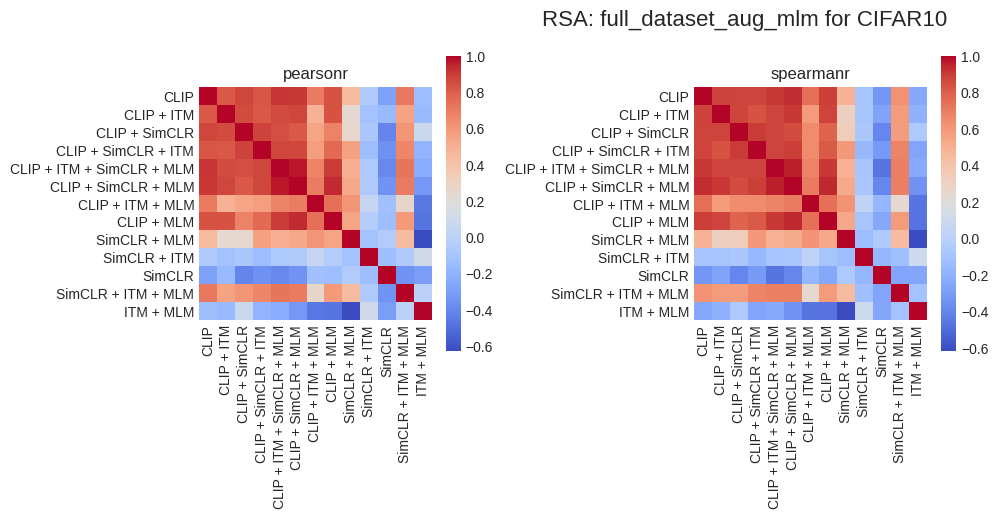

In [ ]:
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(15, 5))
plt.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=16)

for sind, sim in enumerate(similarity_measure):
    plt.subplot(1, 3, sind + 1)
    plt.title(sim)
    rsa_matrix = get_rsa_matrix(visual_representations, text_representations, rsa_similarity_measure=sim, rdm_similarity_measure="cosine")
    plt.imshow(rsa_matrix, cmap="coolwarm")
    plt.yticks(
        [x for x in range(len(visual_representations.keys()))], 
        [cfg_checkpoints[k]["model"] for k in visual_representations.keys()],
    )
    plt.xticks(
        [x for x in range(len(visual_representations.keys()))],
        [cfg_checkpoints[k]["model"] for k in visual_representations.keys()],
        rotation=90,
    )
    plt.colorbar()#fraction=0.045)

plt.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-{DATASET_SPLIT}.png"), bbox_inches="tight"
# )

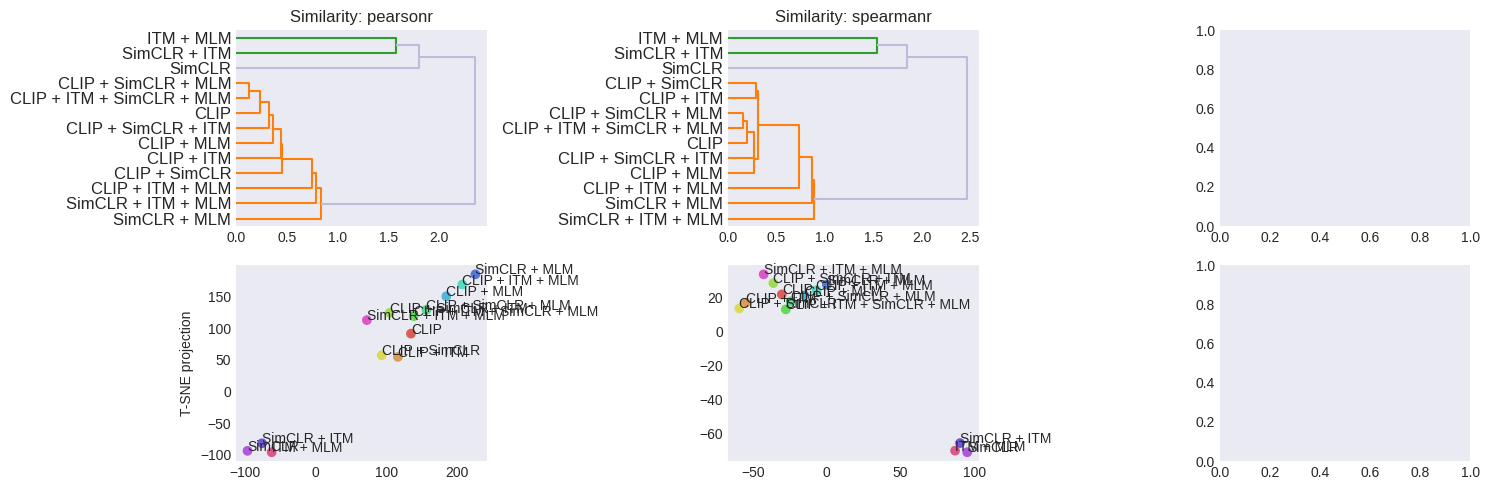

In [ ]:
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8-dark")

labels = [cfg_checkpoints[k]["model"] for k in visual_representations.keys()]
fig, axes = plt.subplots(2, 3, figsize=(15, 5), height_ratios=[1, 1])

axes[1, 0].set_ylabel("T-SNE projection")

for sind, sim in enumerate(similarity_measure):
    rsa_matrix = get_rsa_matrix(visual_representations, text_representations, rsa_similarity_measure=sim)
    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axes[0, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )
    axes[0, sind].set_title(f"Similarity: {sim}")

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axes[1, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 13),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axes[1, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)

fig.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-tsne_dendrogram-{DATASET_SPLIT}.png"),
#     bbox_inches="tight",
# )

### Between uni-modal RDMs of different modalities (Visual RDM vs. Textual RDM)

In [8]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

visual_representations = {}
text_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-visual_representations.pkl"
    file_path = os.path.join(save_file_dir, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        visual_representations[ckpt] = pickle.load(f)
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-text_representations.pkl"
    file_path = os.path.join(save_file_dir, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        text_representations[ckpt] = pickle.load(f)


Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-visual_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-visual_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-visual_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-visual_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-visual_representations.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-visual_representations.pkl
Loading mean class representations from /home/phisch

In [9]:
visual_representations["3burj4np"]

{'dataset': 'CIFAR10',
 'model': '3burj4np',
 'class_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'representations': [{'modality': 'vision',
   'layer': 'visual_projection',
   'data': array([[ 1.27337381e-01, -1.27487266e+00,  4.99394000e-01, ...,
           -1.13992676e-01,  1.30323038e-01, -2.26826727e-01],
          [-4.60895039e-02, -1.53717566e+00,  5.26895046e-01, ...,
            3.20023090e-01, -5.90227321e-02,  9.68287364e-02],
          [ 4.21205342e-01, -8.55829358e-01,  3.59362721e-01, ...,
            3.10472488e-01,  6.53530538e-01, -2.42409676e-01],
          ...,
          [ 3.00776422e-01, -9.94611323e-01,  3.15340906e-01, ...,
           -5.65047795e-03,  3.13719690e-01, -7.70199001e-01],
          [ 1.84451729e-01, -1.23705184e+00,  5.18404782e-01, ...,
           -3.13800216e-01,  2.16681466e-01, -2.31672600e-01],
          [-8.23916793e-02, -1.56125832e+00,  4.75745976e-01, ...,
           -

In [11]:
checkpoints = "full_dataset_aug_mlm"

# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, "full_dataset_mlm")
save_file_dir_2 = os.path.join(SAVE_DATA_DIR, dataset_name, "full_dataset_aug")
save_file_dir_2 = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl"
    if "MLM" in cfg_checkpoints[ckpt]["model"]:
        file_path = os.path.join(save_file_dir, file_name)
    else:
        file_path = os.path.join(save_file_dir_2, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/

In [7]:
for ckpt in cfg_checkpoints:
    print(cfg_checkpoints[ckpt]["model"], ckpt)

CLIP 3burj4np
CLIP + ITM 7m9tx2jf
CLIP + SimCLR 95ddsmmz
CLIP + SimCLR + ITM ng70n4a4
SimCLR p99godxb
SimCLR + ITM xpbl8wfc
SimCLR + ITM + MLM bj2tw5qt
CLIP + ITM + MLM khb9ltyn
ITM + MLM mkqp8hhx
CLIP + SimCLR + MLM txva2y48
CLIP + MLM shf56cne
SimCLR + MLM gtp8w6c4
CLIP + ITM + SimCLR + MLM tibwkymx


In [10]:
assert visual_representations.keys() == text_representations.keys()

In [11]:
similarity_measure = [
    "pearsonr",
    "spearmanr",
    "riemann",
]

def get_rsa_matrix(reps_img, reps_txt, rsa_similarity_measure, rdm_similarity_measure="cosine"):
    assert len(reps_img) == len(reps_txt)
    rsa_matrix = np.zeros((len(reps_img), len(reps_img)))
    for i, key1 in enumerate(reps_img):
        for j, key2 in enumerate(reps_txt):
            rdm_img = rsa.get_rdm(reps_img[key1], metric=rdm_similarity_measure)
            rdm_txt = rsa.get_rdm(reps_txt[key2], metric=rdm_similarity_measure)

            rsaval = rsa.get_rsa(rdm_img, rdm_txt, similarity_measure=rsa_similarity_measure)
            # print (rsaval)
            if rsa_similarity_measure != "riemann":
                rsa_matrix[i, j] = rsaval.statistic
            else:
                rsa_matrix[i, j] = rsaval
    return rsa_matrix

# model_order = ["SimCLR", "SimCLR + ITM", "CLIP + SimCLR", "CLIP + SimCLR + ITM", "CLIP + ITM", "CLIP"]
# model_order = [ # full_dataset_mlm
#     "shf56cne", # CLIP + MLM
#     "khb9ltyn", # "CLIP + ITM + MLM"
#     "txva2y48", # "CLIP + SimCLR + MLM"
#     "tibwkymx", # "CLIP + ITM + SimCLR + MLM
#     "bj2tw5qt", # "SimCLR + ITM + MLM"
#     "gtp8w6c4", # "SimCLR + MLM"
#     "mkqp8hhx", # "ITM + MLM"
# ]
# model_order = [ # full_dataset_aug
#     "3burj4np", # CLIP
#     "7m9tx2jf", # CLIP + ITM
#     "95ddsmmz", # CLIP + SimCLR
#     "ng70n4a4", # CLIP + SimCLR + ITM
#     "xpbl8wfc", # SimCLR + ITM
#     "p99godxb", # SimCLR
# ]
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + ITM + SimCLR + MLM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + ITM + MLM
    "shf56cne", # CLIP + MLM
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
visual_representations = {model: visual_representations[model] for model in model_order}
text_representations = {model: text_representations[model] for model in model_order}
# for model in model_order:

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

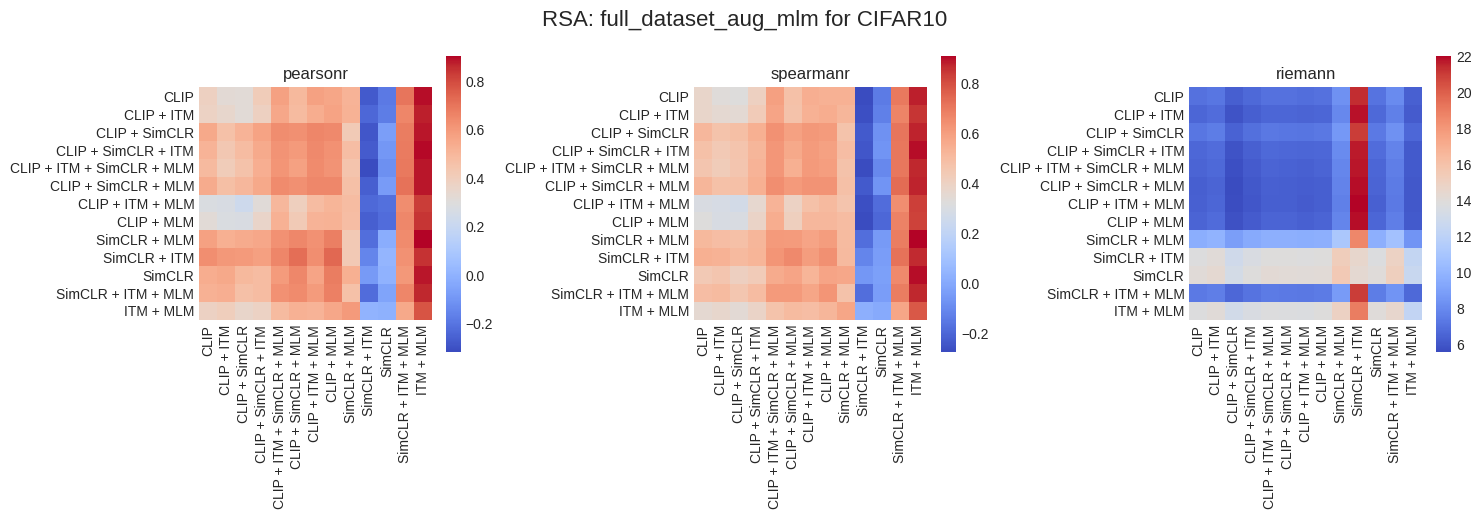

In [ ]:
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(15, 5))
plt.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=16)

for sind, sim in enumerate(similarity_measure):
    plt.subplot(1, 3, sind + 1)
    plt.title(sim)
    rsa_matrix = get_rsa_matrix(visual_representations, text_representations, rsa_similarity_measure=sim, rdm_similarity_measure="cosine")
    plt.imshow(rsa_matrix, cmap="coolwarm")
    plt.yticks(
        [x for x in range(len(visual_representations.keys()))], 
        [cfg_checkpoints[k]["model"] for k in visual_representations.keys()],
    )
    plt.xticks(
        [x for x in range(len(visual_representations.keys()))],
        [cfg_checkpoints[k]["model"] for k in visual_representations.keys()],
        rotation=90,
    )
    plt.colorbar()#fraction=0.045)

plt.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-{DATASET_SPLIT}.png"), bbox_inches="tight"
# )

In [25]:
grouped = group_text_reps_by_template_count(text_representations)
grouped

defaultdict(dict,
            {0: {'3burj4np': array([[-0.18444593, -4.1971936 ,  0.4350224 , ..., -0.11488366,
                       0.04297112, -0.55725986],
                     [-0.17353919, -2.5458887 , -0.10753851, ..., -0.00722754,
                       0.4122421 ,  0.4272802 ],
                     [ 1.5176101 , -2.7835772 ,  0.8642198 , ..., -0.38685885,
                       0.96316296,  0.1202345 ],
                     ...,
                     [ 0.3133119 , -2.4949312 ,  0.4208277 , ..., -0.61346394,
                       0.03362072, -0.49586704],
                     [-0.823829  , -1.4622263 ,  0.31852955, ..., -0.6193323 ,
                       0.27171147, -0.09510045],
                     [-0.48142585, -4.150473  ,  0.20283005, ...,  0.2011725 ,
                       0.10299525, -0.9592819 ]], dtype=float32),
              '7m9tx2jf': array([[ 1.96519680e-03, -3.81211638e+00,  7.62315750e-01, ...,
                      -6.18506908e-01,  1.03370085e-01, -5.3363108

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

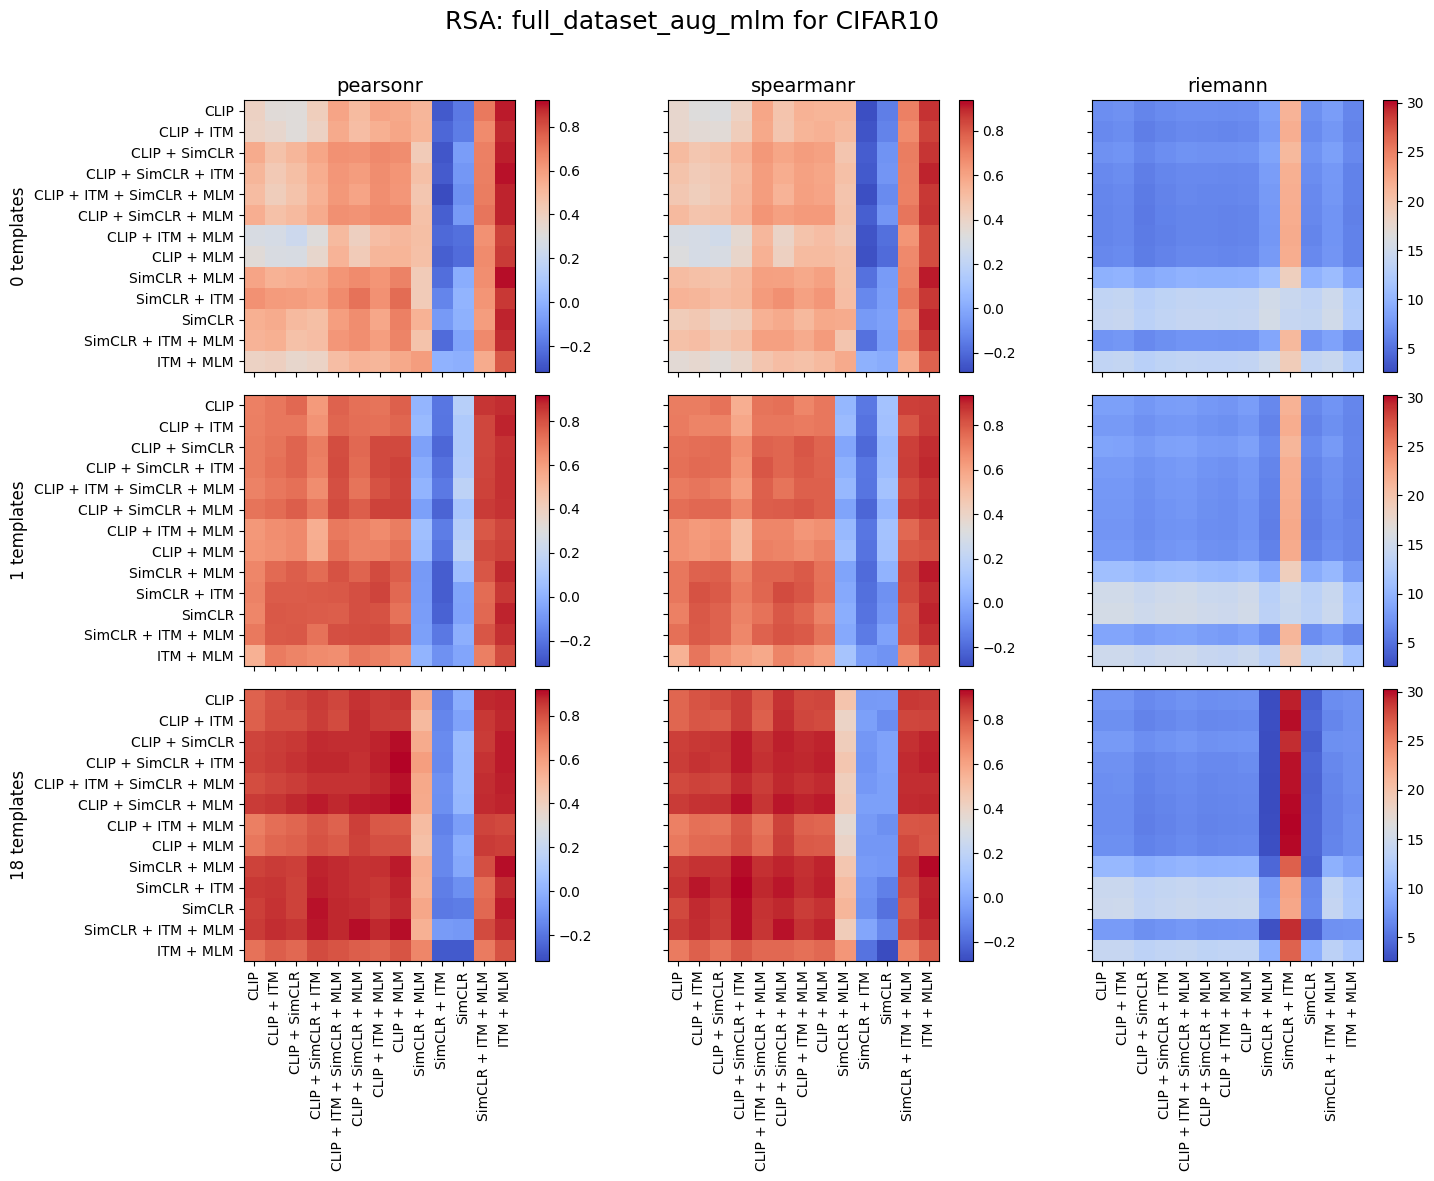

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def get_layer_representation(rep_dict, layer_name):
    """Extracts the representation with the given layer name from a model's dict."""
    for rep in rep_dict["representations"]:
        if rep.get("layer") == layer_name:
            return rep["data"]
    raise ValueError(f"Layer {layer_name} not found in representations.")

def group_text_reps_by_template_count(text_representations):
    """Groups text representations by number of templates."""
    grouped = defaultdict(dict)  # {n_templates: {ckpt: rep_data}}
    for ckpt, rep_dict in text_representations.items():
        for rep in rep_dict["representations"]:
            if rep.get("modality") == "text":
                if rep.get("templates") == ["{}"]:
                    n_templates = 0
                else:
                    n_templates = len(rep.get("templates", []))
                grouped[n_templates][ckpt] = rep["data"]
    return grouped

def get_rsa_matrix_visual_vs_text(visual_reps, text_reps, similarity_measure, rdm_similarity_measure="cosine"):
    """Computes RSA matrix between visual and text RDMs for all models."""
    keys = list(visual_reps.keys())
    n = len(keys)
    rsa_matrix = np.zeros((n, n))
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys):
            vis = get_layer_representation(visual_reps[k1], "visual_projection")
            txt = text_reps[k2]
            rdm_vis = rsa.get_rdm(vis, metric=rdm_similarity_measure)
            rdm_txt = rsa.get_rdm(txt, metric=rdm_similarity_measure)
            rsaval = rsa.get_rsa(rdm_vis, rdm_txt, similarity_measure=similarity_measure)
            if similarity_measure != "riemann":
                rsa_matrix[i, j] = rsaval.statistic
            else:
                rsa_matrix[i, j] = rsaval
    return rsa_matrix

# --- Main plotting code ---

similarity_measures = ["pearsonr", "spearmanr", "riemann"]
template_groups = group_text_reps_by_template_count(text_representations)
template_counts = sorted(template_groups.keys())
num_rows = len(template_counts)
num_cols = len(similarity_measures)
model_labels = [cfg_checkpoints[k]["model"] for k in visual_representations.keys()]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
fig.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=18)

# Compute vmin/vmax per column for color normalization
vmin_per_col = []
vmax_per_col = []
for col, sim in enumerate(similarity_measures):
    all_vals = []
    for n_templates in template_counts:
        rsa_mat = get_rsa_matrix_visual_vs_text(
            visual_representations, template_groups[n_templates], sim
        )
        all_vals.append(rsa_mat)
    all_vals = np.stack(all_vals)
    vmin_per_col.append(all_vals.min())
    vmax_per_col.append(all_vals.max())

for row, n_templates in enumerate(template_counts):
    text_reps = template_groups[n_templates]
    for col, sim in enumerate(similarity_measures):
        ax = axes[row, col] if num_rows > 1 else axes[col]
        rsa_matrix = get_rsa_matrix_visual_vs_text(
            visual_representations, text_reps, sim
        )
        im = ax.imshow(rsa_matrix, cmap="coolwarm", vmin=vmin_per_col[col], vmax=vmax_per_col[col])
        if row == num_rows - 1:
            ax.set_xticks(range(len(model_labels)))
            ax.set_xticklabels(model_labels, rotation=90)
        else:
            ax.set_xticks(range(len(model_labels)))
            ax.set_xticklabels([])
        ax.set_yticks(range(len(model_labels)))
        if col == 0:
            ax.set_yticklabels(model_labels)
            ax.set_ylabel(f"{n_templates} templates", fontsize=12)
        else:
            ax.set_yticklabels([])
        if row == 0:
            ax.set_title(sim, fontsize=14)
        fig.colorbar(im, ax=ax, fraction=0.045)

fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
text_representations["3burj4np"]["representations"]

[{'modality': 'text',
  'layer': 'text_projection',
  'templates': ['{}'],
  'data': array([[-0.18444593, -4.1971936 ,  0.4350224 , ..., -0.11488366,
           0.04297112, -0.55725986],
         [-0.17353919, -2.5458887 , -0.10753851, ..., -0.00722754,
           0.4122421 ,  0.4272802 ],
         [ 1.5176101 , -2.7835772 ,  0.8642198 , ..., -0.38685885,
           0.96316296,  0.1202345 ],
         ...,
         [ 0.3133119 , -2.4949312 ,  0.4208277 , ..., -0.61346394,
           0.03362072, -0.49586704],
         [-0.823829  , -1.4622263 ,  0.31852955, ..., -0.6193323 ,
           0.27171147, -0.09510045],
         [-0.48142585, -4.150473  ,  0.20283005, ...,  0.2011725 ,
           0.10299525, -0.9592819 ]], dtype=float32),
  'embedding_dim': 512,
  'dtype': 'float32',
  'created': '2025-05-22',
  'notes': ''},
 {'modality': 'text',
  'layer': 'text_projection',
  'templates': ['a photo of a {}.'],
  'data': array([[-0.48910576, -3.184953  ,  0.45837057, ..., -0.61260366,
         

AttributeError: 'NoneType' object has no attribute 'statistic'

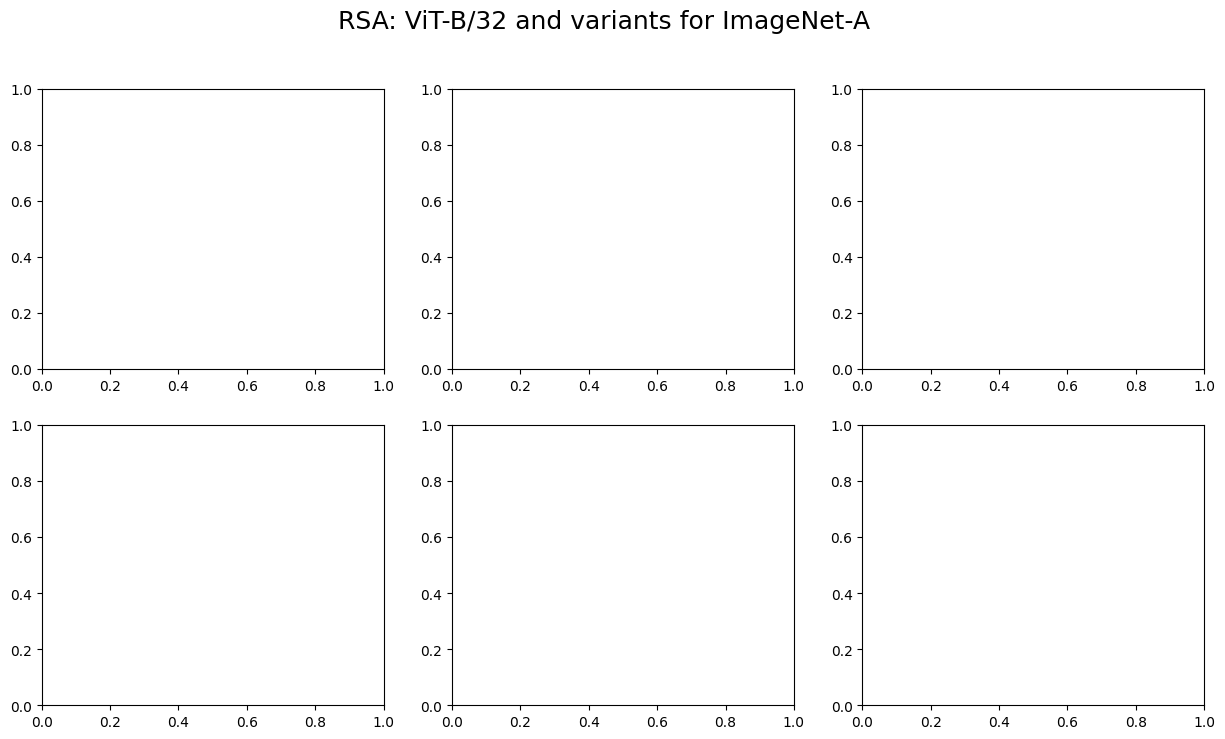

In [ ]:
def plot_rsa_grid_from_representations(mean_class_representations_img, text_rep_dict,
                                       similarity_measures, cfg_checkpoints,
                                       dataset_name, checkpoints):
    """
    Plot RSA matrices for different template counts from the given text_rep_dict.

    Parameters:
        - mean_class_representations_img: dict of image reps per model
        - text_rep_dict: dict like {ckpt: {'representations': [rep1, rep2, ...]}}
        - similarity_measures: list of similarity names (e.g., ["pearson", "spearman", "riemann"])
        - cfg_checkpoints: dict mapping checkpoint names to display names
        - dataset_name: name of dataset
        - checkpoints: string or list of checkpoint names used
    """
    # Step 1: group text representations by number of templates
    from collections import defaultdict

    reps_by_template_count = defaultdict(dict)  # e.g., {1: {ckpt1: rep_dict, ckpt2: rep_dict}, 4: {...}, ...}
    for ckpt, entry in text_rep_dict.items():
        for rep in entry["representations"]:
            if rep["modality"] != "text":
                continue
            n_templates = len(rep["templates"])
            reps_by_template_count[n_templates][ckpt] = rep["data"]

    template_counts = sorted(reps_by_template_count.keys())
    num_rows = len(template_counts)
    num_cols = len(similarity_measures)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    fig.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=18)

    # Normalize colorbars across columns
    vmin_per_col = []
    vmax_per_col = []

    for col, sim in enumerate(similarity_measures):
        all_vals = []
        for rep_dict in reps_by_template_count.values():
            rsa_matrix = get_rsa_matrix(mean_class_representations_img, rep_dict,
                                        rsa_similarity_measure=sim,
                                        rdm_similarity_measure="cosine")
            all_vals.append(rsa_matrix)
        all_vals = np.stack(all_vals)
        vmin_per_col.append(all_vals.min())
        vmax_per_col.append(all_vals.max())

    for row, n_templates in enumerate(template_counts):
        text_reps = reps_by_template_count[n_templates]

        for col, sim in enumerate(similarity_measures):
            ax = axes[row, col] if num_rows > 1 else axes[col]

            rsa_matrix = get_rsa_matrix(mean_class_representations_img, text_reps,
                                        rsa_similarity_measure=sim,
                                        rdm_similarity_measure="cosine")

            im = ax.imshow(rsa_matrix, cmap="coolwarm", vmin=vmin_per_col[col], vmax=vmax_per_col[col])
            ax.set_xticks(range(len(mean_class_representations_img)))
            ax.set_xticklabels([cfg_checkpoints[k]["model"] for k in mean_class_representations_img], rotation=90)
            ax.set_yticks(range(len(mean_class_representations_img)))

            if col == 0:
                ax.set_yticklabels([cfg_checkpoints[k]["model"] for k in mean_class_representations_img])
                ax.set_ylabel(f"{n_templates} templates", fontsize=12)
            else:
                ax.set_yticklabels([])

            if row == 0:
                ax.set_title(sim, fontsize=14)

            fig.colorbar(im, ax=ax, fraction=0.045)

    fig.tight_layout(rect=[0, 0, 1, 0.97])


plot_rsa_grid_from_representations(
    visual_representations,
    text_representations,  # this is your dict with checkpoint -> {"representations": [...]}
    similarity_measures=["pearson", "spearman", "riemann"],
    cfg_checkpoints=cfg_checkpoints,
    dataset_name="ImageNet-A",
    checkpoints="ViT-B/32 and variants"
)


Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

/tmp/ipykernel_535556/3173755742.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  z = hierarchy.linkage(rsa_matrix)


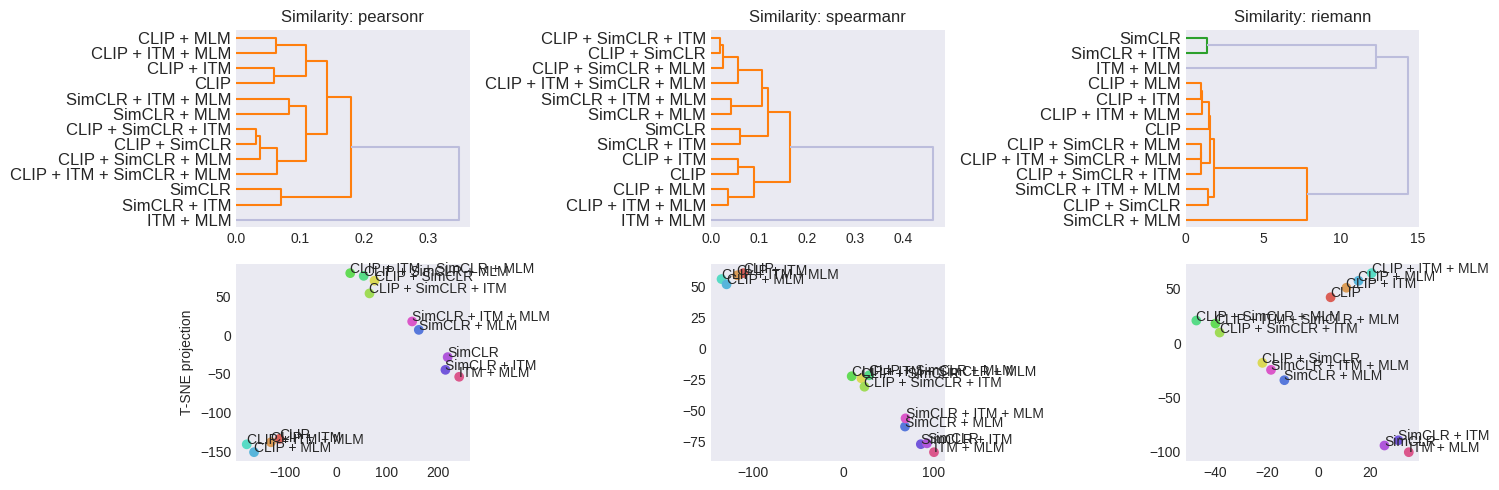

In [ ]:
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8-dark")

labels = [cfg_checkpoints[k]["model"] for k in mean_class_representations.keys()]
fig, axes = plt.subplots(2, 3, figsize=(15, 5), height_ratios=[1, 1])

axes[1, 0].set_ylabel("T-SNE projection")

for sind, sim in enumerate(similarity_measure):
    rsa_matrix = get_rsa_matrix(mean_class_representations, rsa_similarity_measure=sim)
    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axes[0, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )
    axes[0, sind].set_title(f"Similarity: {sim}")

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axes[1, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 13),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axes[1, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)

fig.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-tsne_dendrogram-{DATASET_SPLIT}.png"),
#     bbox_inches="tight",
# )